In [3]:
pip install pandas matplotlib numpy scikit-learn scipy seaborn mpl_toolkits ipympl

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement mpl_toolkits (from versions: none)
ERROR: No matching distribution found for mpl_toolkits

[notice] A new release of pip is available: 23.2.1 -> 24.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
pip install ipympl


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
%matplotlib widget

# Preparing the data

In [6]:
# 1. Firstly, before we construct the CRO algorithm we will need to load in our data that we will train the model with
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
import numpy as np
import seaborn as sns

# Load in data from CSV file, I used Kaggle for this
data_csv = pd.read_csv("GaltonFamilies.csv")

In [7]:
# Remember that regression uses only quantitative variables, so we should filter columns with any non number columns

# Identify numerical columns
numerical_columns = data_csv.select_dtypes(include=['number']).columns

# Create a new DataFrame with only numerical columns
data_csv = data_csv[numerical_columns]


# Testing when looking at only specified columns
columns_to_keep = ['father', 'mother', 'childHeight']
data_csv = data_csv[columns_to_keep]


In [8]:
data_csv.head

<bound method NDFrame.head of      father  mother  childHeight
0      78.5    67.0         73.2
1      78.5    67.0         69.2
2      78.5    67.0         69.0
3      78.5    67.0         69.0
4      75.5    66.5         73.5
..      ...     ...          ...
929    62.0    66.0         64.0
930    62.0    66.0         62.0
931    62.0    66.0         61.0
932    62.5    63.0         66.5
933    62.5    63.0         57.0

[934 rows x 3 columns]>

# Clustering the data

[[68.33118279569892, 63.55537634408602, 61.851612903225806], [68.83010752688172, 63.78978494623656, 64.53118279569892], [69.21612903225807, 64.12096774193549, 66.5725806451613], [69.51397849462366, 64.05483870967743, 68.92956989247313], [70.07526315789474, 64.90789473684211, 71.73736842105264]]


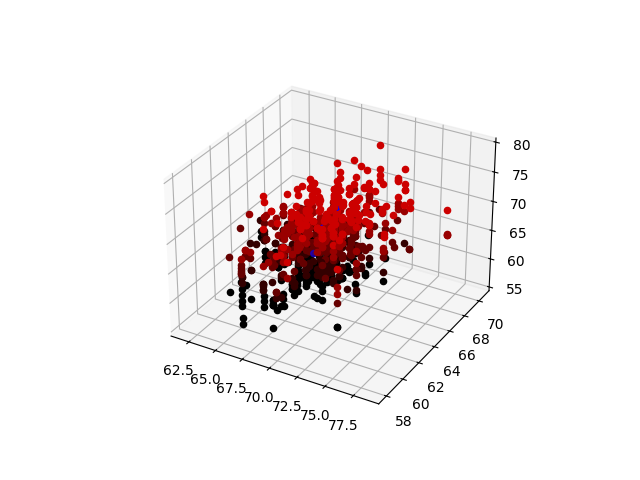

In [36]:
# We will cluster our data into approximated points with the following logic:

"""
Choose an arbitrary dimension, then go from intervals of desired length, look at all data points within interval, then generate averages for each cluster detected
"""
# TODO: Find which column to cluster by using the lowest loss function value

# First sort our data set given the row we choose to cluster by
chosen_column = 'childHeight'

# Sort the dataset by the chosen column
data_csv_sorted = data_csv.sort_values(by=chosen_column)
chunk_amount = 5 # amount of desired chunks
chunk_size = 20 # amount of desired points in each chunk



# Pseudocode below
"""
for chunk in chunks:
    cluster_list = makeClusters(chunk)
    aprox_vectors = []
    
    for cluster in cluster_list:
        aprox_vectors.append(cluster.mean)

return aprox_vectors
"""

# A chunk is defined as a group of data points with relatively close proximity
def generate_chunks(data):
    chunk_list = []
    chunk_size = len(data) // chunk_amount
    for i in range(chunk_amount):
        start_index = i * chunk_size
        end_index = start_index + chunk_size if i < chunk_amount - 1 else len(data)
        chunk_list.append(data[start_index:end_index])
    return chunk_list


# Function to determine the optimal number of clusters
def determine_optimal_cluster_count(data, max_clusters=10, sensitivity=0.95):
    if len(data) <= 1:
        return 1  # Can't cluster if there's only one point
    distortions = []
    for k in range(1, min(len(data), max_clusters) + 1):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(data)
        distortions.append(kmeans.inertia_)
    # Heuristic: choose the number of clusters where the reduction in inertia decreases significantly
    k_opt = 1
    for i in range(1, len(distortions)):
        if distortions[i-1] - distortions[i] < sensitivity * (distortions[0] - distortions[-1]):
            k_opt = i
            break
    return k_opt

color_index = 0
ax = plt.figure().add_subplot(projection='3d')

# Function to generate cluster averages
def generate_cluster_averages(chunk, num_clusters):
    global color_index
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(chunk)
    cluster_centers = kmeans.cluster_centers_
    
    for (x, y, z) in zip(chunk['father'], chunk['mother'], chunk['childHeight']):
        ax.scatter(x, y, z, color=(color_index * (1 / chunk_amount), 0, 0))
    color_index += 1
    return cluster_centers.tolist()


# fig = plt.figure(figsize=(10, 6))
# ax = fig.add_subplot(111, projection='3d')
# scatter = ax.scatter(all_data_points_df['father'], all_data_points_df['mother'], all_data_points_df['childHeight'], c=all_labels, cmap='viridis', marker='o')



# Generate chunks
chunks = generate_chunks(data_csv_sorted)
# print(chunks[0])

# Initialize list to store cluster averages
cluster_averages = []

# Generate cluster averages for each chunk
for chunk in chunks:
    # print(chunk)
    cluster_averages.extend(generate_cluster_averages(chunk, determine_optimal_cluster_count(chunk)))

# Plotting the cluster averages
x_values = [avg[0] for avg in cluster_averages] 
y_values = [avg[1] for avg in cluster_averages]  # Assuming cluster averages are 1D, adjust if they are multidimensional
z_values = [avg[2] for avg in cluster_averages]

ax.scatter(x_values, y_values, z_values, color='blue')

print(cluster_averages)



Each shade of red above is denoted as a separate cluster which has its own approximation vector

# Connecting approximation points

In [39]:
# Value functions to determine the connection strength between two points

density_bias = -0.2
distance_bias = -1

# Function to calculate Euclidean distance between two points
def get_euclidean_distance(point1, point2):
    point1 = np.array(point1)
    point2 = np.array(point2)
    return np.sqrt(np.sum(np.square(point1 - point2)))



# Function to calculate the density value between two points for any dimension
def density_value(p1, p2, data):
    min_coords = np.minimum(p1, p2)
    max_coords = np.maximum(p1, p2)
    
    # Create a boolean mask to filter points within the bounding box
    mask = np.ones(len(data), dtype=bool)
    for i, (min_coord, max_coord) in enumerate(zip(min_coords, max_coords)):
        mask &= (data[:, i] >= min_coord) & (data[:, i] <= max_coord)
    
    # Number of points within the bounding box
    in_area = data[mask]
    
    # Calculate the size of the bounding box (hyper-rectangle in higher dimensions)
    volume = np.prod(max_coords - min_coords)
    
    # Calculate the density value
    density = (len(in_area) / volume) * density_bias
    
    return density



# Function to calculate the distance value between two points
def distance_value(p1, p2):
    return get_euclidean_distance(p1, p2) * distance_bias



# Function to calculate connection strength between two points
def connection_strength(p1, p2, data):
    return density_value(p1, p2, data) + distance_value(p1, p2)



# Function to generate the sorted list of approximation vectors
def generate_approximation_vectors(data, cluster_averages):
    # Initialize the sorted list of approximation vectors
    sorted_approx_vectors = []
    
    # Initialize the list of points that have been connected
    connected_points = []
    
    # Start with the point closest to the origin
    origin = np.zeros(len(cluster_averages[0]))
    closest_to_origin_idx = np.argmin([get_euclidean_distance(origin, avg) for avg in cluster_averages])
    
    # Add the closest point to the origin to the sorted list and mark it as connected
    sorted_approx_vectors.append(cluster_averages[closest_to_origin_idx])
    connected_points.append(closest_to_origin_idx)
    
    while len(connected_points) < len(cluster_averages):
        last_point_idx = connected_points[-1]
        last_point = cluster_averages[last_point_idx]
        
        # Calculate connection strengths to all other unconnected points
        connection_strengths = []
        for i, avg in enumerate(cluster_averages):
            if i not in connected_points:
                strength = connection_strength(last_point, avg, data)
                connection_strengths.append((strength, i))
        
        # Sort the connection strengths in descending order and get the best one
        connection_strengths.sort(reverse=True, key=lambda x: x[0])
        best_connection_idx = connection_strengths[0][1]
        
        # Add the best connected point to the sorted list and mark it as connected
        sorted_approx_vectors.append(cluster_averages[best_connection_idx])
        connected_points.append(best_connection_idx)
    
    return sorted_approx_vectors



# Example usage
data = data_csv_sorted[['father', 'mother', 'childHeight']].values
sorted_approx_vectors = generate_approximation_vectors(data, cluster_averages)

print("Sorted Approximation Vectors:")
print(sorted_approx_vectors)

Sorted Approximation Vectors:
[[68.33118279569892, 63.55537634408602, 61.851612903225806], [68.83010752688172, 63.78978494623656, 64.53118279569892], [69.21612903225807, 64.12096774193549, 66.5725806451613], [69.51397849462366, 64.05483870967743, 68.92956989247313], [70.07526315789474, 64.90789473684211, 71.73736842105264]]


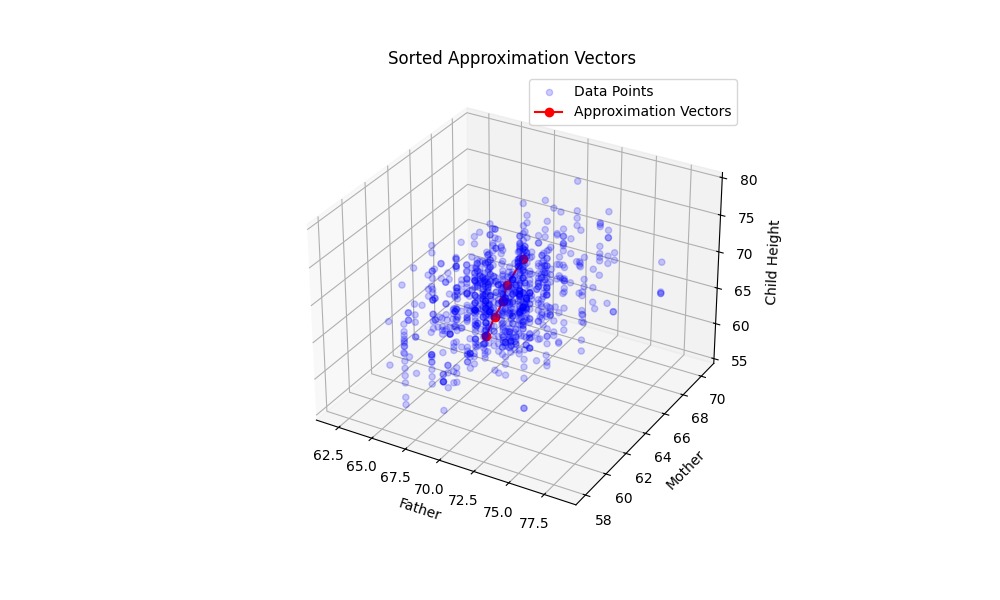

In [40]:
# Lets plot the sorted approximation vectors
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data[:, 0], data[:, 1], data[:, 2], c='blue', marker='o', label='Data Points', alpha=0.2)
ax.plot(np.array(sorted_approx_vectors)[:, 0], np.array(sorted_approx_vectors)[:, 1], np.array(sorted_approx_vectors)[:, 2], c='red', marker='o', label='Approximation Vectors')
ax.set_xlabel('Father')
ax.set_ylabel('Mother')
ax.set_zlabel('Child Height')
ax.set_title('Sorted Approximation Vectors')
ax.legend()

plt.show()


# Optimize via gradient descent

Iteration 0, Loss: 3.0191549161652556
Iteration 100, Loss: 3.019058072909199
Iteration 200, Loss: 3.01896782715004
Iteration 300, Loss: 3.0188801476163776
Iteration 400, Loss: 3.018788503014316
Iteration 500, Loss: 3.0186990388703925
Iteration 600, Loss: 3.0186171441036196
Iteration 700, Loss: 3.0185381966779863
Iteration 800, Loss: 3.0184648358527397
Iteration 900, Loss: 3.0183991949301245
Iteration 1000, Loss: 3.0183413031574386
Iteration 1100, Loss: 3.0182911902800305
Iteration 1200, Loss: 3.01824888658161
Iteration 1300, Loss: 3.0182072911546753
Iteration 1400, Loss: 3.0181726709979
Iteration 1500, Loss: 3.0181438290139893
Iteration 1600, Loss: 3.0181200131172985
Iteration 1700, Loss: 3.018098180467144
Iteration 1800, Loss: 3.0180754557490523
Iteration 1900, Loss: 3.0180606027133035
Optimized Approximation Vectors:
[[68.30725374 63.53992178 61.71334894]
 [68.81784527 63.77798875 64.46363307]
 [69.21645263 64.12111224 66.56929465]
 [69.52185874 64.05037777 68.99716389]
 [70.09875131

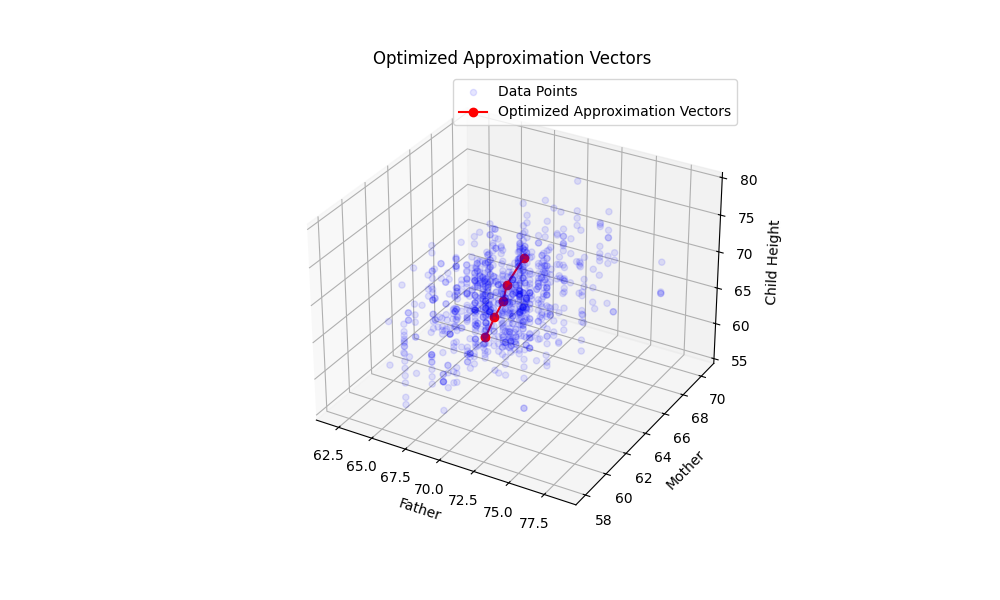

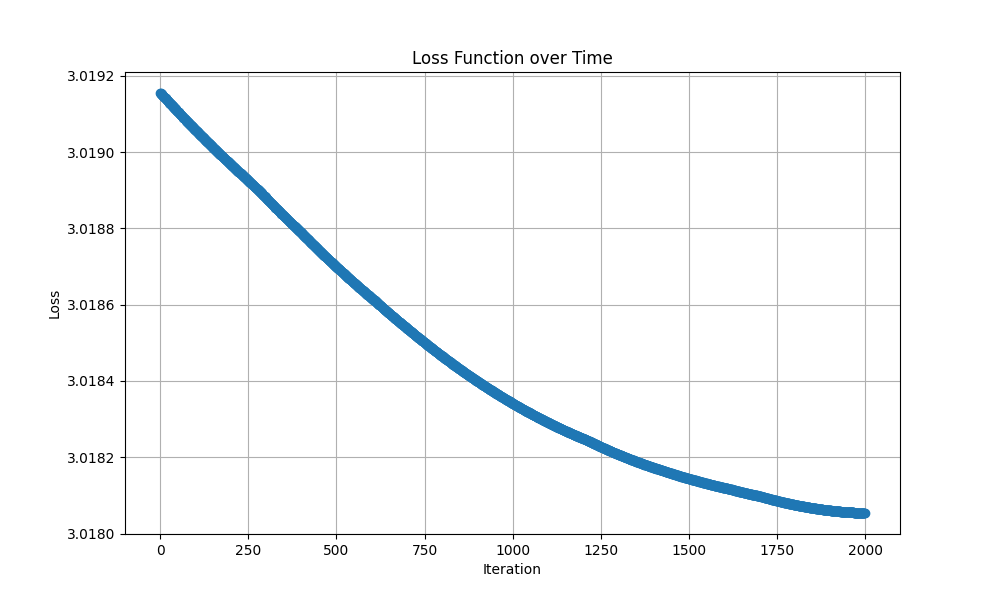

In [53]:

# Loss function to determine the quality of the approximation
def loss_function(data, approx_vectors):
    loss = 0
    for point in data:
        min_dist = np.inf
        for approx_vector in approx_vectors:
            dist = get_euclidean_distance(point, approx_vector)
            if dist < min_dist:
                min_dist = dist
        loss += min_dist
    return loss / len(data)

# Gradient descent to minimize the loss function
learning_rate = 0.0001
num_iterations = 2000

# Initialize the approximation vectors with the sorted approximation vectors
approx_vectors = np.array(cluster_averages)

# Perform gradient descent
losses = []

for i in range(num_iterations):
    # Calculate the gradient of the loss function with respect to each coordinate of each approximation vector
    gradient = np.zeros(approx_vectors.shape)
    
    for j, approx_vector in enumerate(approx_vectors):
        for k in range(approx_vector.shape[0]):  # Iterate over each coordinate
            grad = 0
            for point in data:
                dist = get_euclidean_distance(point, approx_vector)
                if dist > 0:  # Avoid division by zero
                    grad -= (approx_vector[k] - point[k]) / dist
            gradient[j][k] = grad / len(data)
    
    # Update the approximation vectors
    approx_vectors -= learning_rate * gradient
    
    # Calculate the loss after this iteration
    loss = loss_function(data, approx_vectors)
    losses.append(loss)
    
    # Print the loss every 100 iterations
    if i % 100 == 0:
        print(f"Iteration {i}, Loss: {loss}")

# Calculate the final optimized loss
optimized_loss = loss_function(data, approx_vectors)

print("Optimized Approximation Vectors:")
print(approx_vectors)
print("Optimized Loss:", optimized_loss)

# Plot the optimized approximation vectors
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data[:, 0], data[:, 1], data[:, 2], c='blue', marker='o', label='Data Points', alpha=0.1)
ax.plot(approx_vectors[:, 0], approx_vectors[:, 1], approx_vectors[:, 2], c='red', marker='o', label='Optimized Approximation Vectors')
ax.set_xlabel('Father')
ax.set_ylabel('Mother')
ax.set_zlabel('Child Height')
ax.set_title('Optimized Approximation Vectors')
ax.legend()
plt.show()


# Plot the loss function over time
plt.figure(figsize=(10, 6))
plt.plot(range(num_iterations), losses, marker='o')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss Function over Time')
plt.grid(True)
plt.show()


Before concluding, I'd like to make some additional comments

More optimizations that could be made:
- Unlike linear regression, we cannot extrapolate on data, this could be solved potentially by extending the beginning and final connection lines
- We could recursively add approximation points in the centers of each connection, than perform more rounds of gradient descent to more closely approach the most efficient hypothesis
- compare training data vs testing data loss and stop early before overfitting occurs
- We sort everything by a single dimension before adding approximation vectors, but we could minimize loss by testing more than just the dimensions (we could cluster the data at an angle by having multiple dimensions be included in a value equation for sorting) -> (instead of sort by a single x,y, or z dimension... we could sort with the lowest to greatest [1.5x + 6y -2z] or any other combination)



I can contacted via william.jamesstobaugh@gmail.com for any comments, questions, or inquiries.
